# Sentiment Analysis Continued (EXPWORDLST-SMOTE-PCA-TRNCTDSVD)- Natural Language Processing 

### Import necessary libraries

In [1]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re

import unicodedata
tokenizer = ToktokTokenizer()
#nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

### Reading the Cleaned Dataset

In [2]:
# Read the file
df3 = pd.read_csv('D:\GENEL\SPRINGBOARD\PROJECTS\CAPSTONE PROJECTS\CAPSTONE PROJECT-2/Reduced_Cleaned_Reviews_Home_and_Kitchen.csv')

## Model Performance Improvements

## 1. Adding Most Common and Lest Common Words to Stopwords List

Since there were not too many distinguisher words in different classes, the most and least common 70 words added to the stopwords list and models were applied in order to see any changes in evaluation metrics.

In [3]:
# Words and Frequencies

cleaned_text = [str(txt) for text in df3['clean_text'] for txt in text.split(' ') 
                if len(txt)>2 and txt not in 'not, nan']

word_dist = nltk.FreqDist(cleaned_text)

### Adding the Most Common and the Least Common 70 Words to the Stopwords List

In [4]:
stopword_list= stopwords.words('english')

for y in word_dist.most_common()[-70:]:
    stopword_list.append(y[0])
    
mst_c = word_dist.most_common()[:70]

for x in mst_c:
    stopword_list.append(x[0])

In [5]:
# Applying the new stopwords List to the Clean Text Column
lemmatizer = WordNetLemmatizer()

df3['clean_text'] = df3['clean_text'].map(lambda text: " ".join([lemmatizer.lemmatize(w) 
                                                               for w in text.split(' ') if w not in stopword_list]))

## Data Preparation

### Separating Response Variable and Feature

In [6]:
df3['rating_class'] = df3['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [7]:
# Splitting the Data Set into Train and Test Sets
X = df3['clean_text']
y = df3['rating_class']

### Splitting Dataset into Train and Test Set

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data.

In [8]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Confusion Matrix Plot Function

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [10]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## Modeling (with CountVectorizer)

In [11]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

### A function for applying different algorithms

In [12]:
def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test, ytrain = y_train):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, ytrain)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

## 1.1 Logistic Regression with CountVectorizer

In [13]:
# Call the modeling function for logistic regression with CountVectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.9242591949908444


### Classification Report

In [14]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.70      0.73      0.72       294
           1       0.96      0.95      0.96      1940

    accuracy                           0.92      2234
   macro avg       0.83      0.84      0.84      2234
weighted avg       0.93      0.92      0.92      2234



### Confusion Matrix

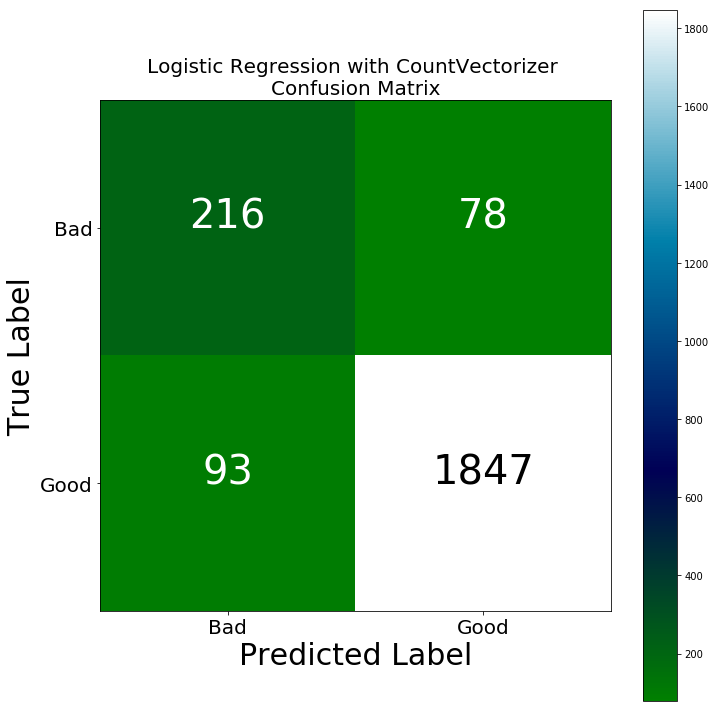

In [15]:
# Print confusion matrix for logistic regression with CountVectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression", "CountVectorizer")

## 1.2 Random Forest with CountVectorizer

In [16]:
# Call the modeling function for random forest classifier with CountVectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.882662838649462


### Classification Report

In [17]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.99      0.29      0.45       294
           1       0.90      1.00      0.95      1940

    accuracy                           0.91      2234
   macro avg       0.95      0.64      0.70      2234
weighted avg       0.91      0.91      0.88      2234



### Confusion Matrix

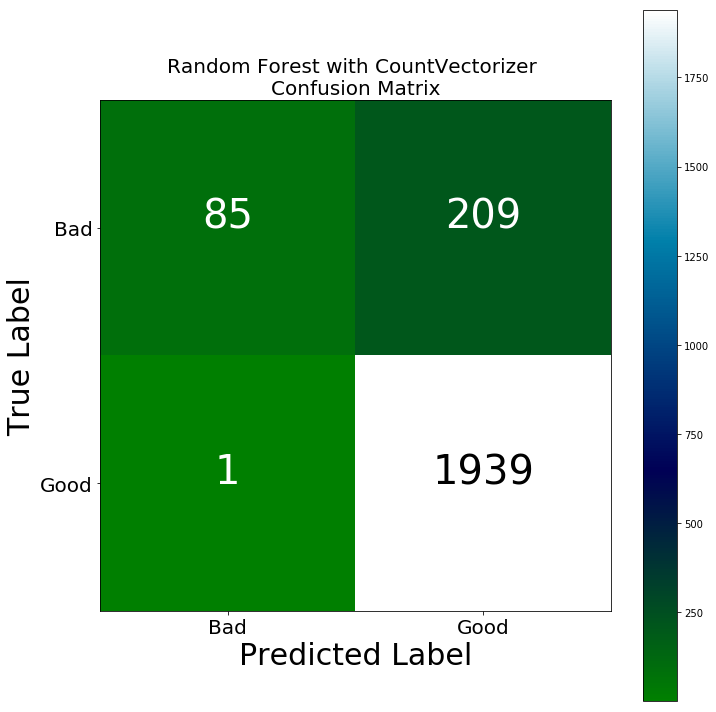

In [18]:
# Print confusion matrix for random forest classifier with CountVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest", "CountVectorizer")

## 1.3 Naive Bayes with CountVectorizer

In [19]:
# Call the modeling function for naive bayes with CountVectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.8659691680909983


### Classification Report

In [20]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.46      0.70      0.56       294
           1       0.95      0.88      0.91      1940

    accuracy                           0.85      2234
   macro avg       0.71      0.79      0.74      2234
weighted avg       0.89      0.85      0.87      2234



### Confusion Matrix

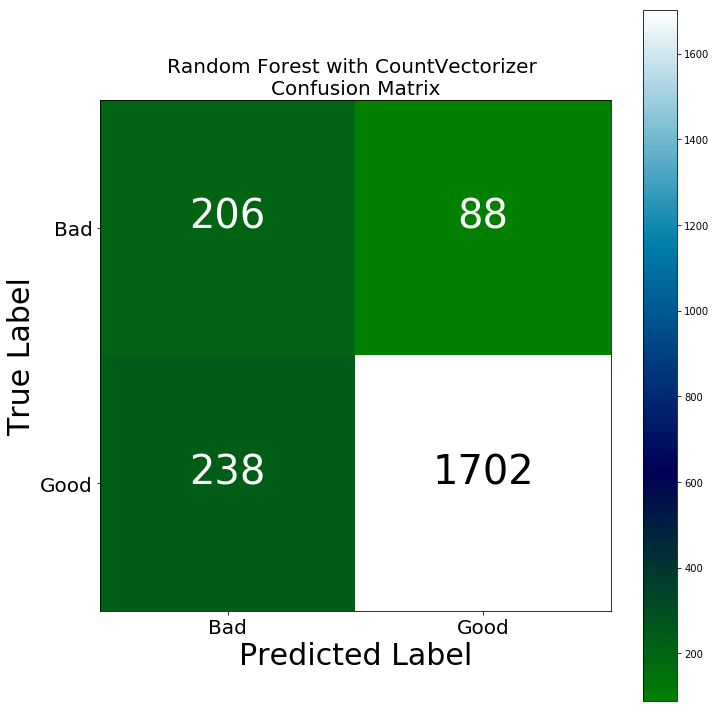

In [21]:
# Print confusion matrix for naive bayes with CountVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Random Forest", "CountVectorizer")

## 1.4 XGBoost with CountVectorizer

In [22]:
# Call the modeling function for XGBoost with CountVectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.9075787860201189


### Classification Report

In [23]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.95      0.42      0.58       294
           1       0.92      1.00      0.96      1940

    accuracy                           0.92      2234
   macro avg       0.94      0.71      0.77      2234
weighted avg       0.92      0.92      0.91      2234



### Confusion Matrix

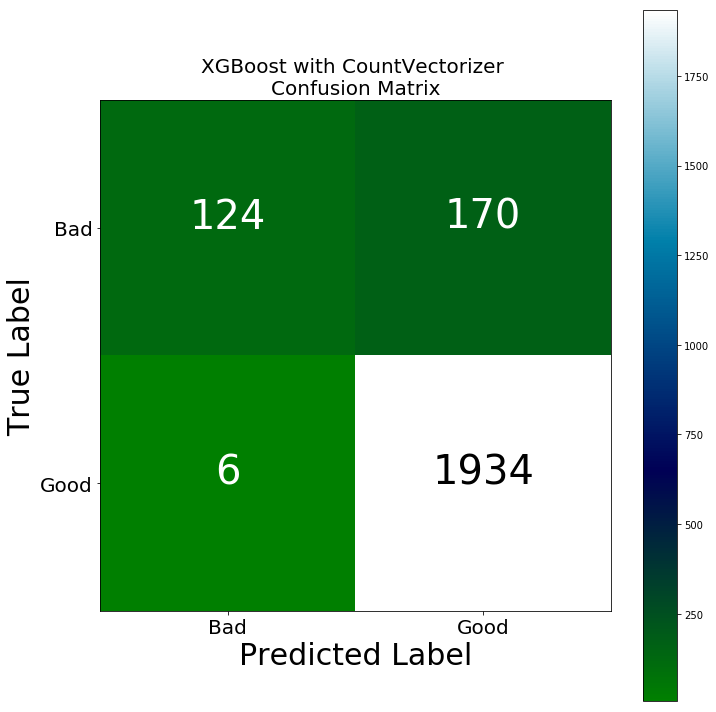

In [24]:
# Print confusion matrix for XGBoost with CountVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost", "CountVectorizer")

## 1.5 Catboosting with CountVectorizer

In [25]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.3513108	total: 89.6ms	remaining: 8.87s
1:	learn: 0.3180472	total: 105ms	remaining: 5.12s
2:	learn: 0.3017863	total: 122ms	remaining: 3.96s
3:	learn: 0.2879042	total: 141ms	remaining: 3.37s
4:	learn: 0.2751583	total: 163ms	remaining: 3.09s
5:	learn: 0.2656723	total: 179ms	remaining: 2.81s
6:	learn: 0.2567477	total: 195ms	remaining: 2.6s
7:	learn: 0.2513340	total: 211ms	remaining: 2.43s
8:	learn: 0.2460204	total: 232ms	remaining: 2.35s
9:	learn: 0.2393478	total: 247ms	remaining: 2.23s
10:	learn: 0.2339151	total: 263ms	remaining: 2.13s
11:	learn: 0.2277172	total: 279ms	remaining: 2.05s
12:	learn: 0.2218695	total: 295ms	remaining: 1.98s
13:	learn: 0.2157623	total: 310ms	remaining: 1.9s
14:	learn: 0.2125664	total: 326ms	remaining: 1.85s
15:	learn: 0.2119599	total: 340ms	remaining: 1.79s
16:	learn: 0.2092083	total: 356ms	remaining: 1.74s
17:	learn: 0.2069739	total: 370ms	remaining: 1.69s
18:	learn: 0.2047013	total: 384ms	remaining: 1.64s
19:	learn: 0.2035670	total: 399ms	remainin

### Classification Report

In [26]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.86      0.54      0.67       294
           1       0.93      0.99      0.96      1940

    accuracy                           0.93      2234
   macro avg       0.90      0.77      0.81      2234
weighted avg       0.92      0.93      0.92      2234



### Confusion Matrix

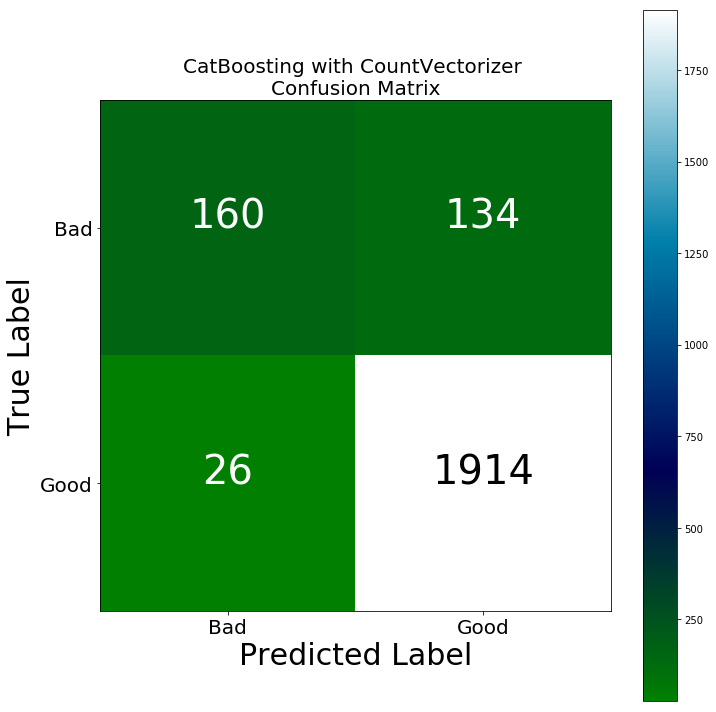

In [27]:
# Print confusion matrix for CatBoost with CountVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting", "CountVectorizer")

## 1.6 Comparision of Models

### Functions for Algorithms Comparison

In [28]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
global comparison_matrix
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [29]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

### Function for f1 score plotting

In [30]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

### Model Comparison Table

In [31]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [32]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with Expanded Stopword List\n')
df_tv2


Comparision Matrix of Modeling with Expanded Stopword List



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.923456 bad       0.699029  0.734694  0.716418   
                                  good      0.959481  0.952062  0.955757   
                                  average   0.925204  0.923456  0.924259   
           Random Forest 0.905998 bad       0.988372  0.289116  0.447368   
                                  good      0.902700  0.999485  0.948630   
                                  average   0.913975  0.905998  0.882663   
           Naive Bayes   0.854073 bad       0.463964  0.700680  0.558266   
                                  good      0.950838  0.877320  0.912601   
                                  average   0.886764  0.854073  0.865969   
           XGBoost       0.921218 bad       0.953846  0.421769  0.584906   
                                  good      0.919202  0.996907  0.956479   
                                  average   0.923761  0.921218  0.907579   
           CatBoost      0.928380 bad       0.860215  0.544218  0.666667   
                                  good      0.934570  0.986598  0.959880   
                                  average   0.924785  0.928380  0.921292   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.923456 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           Random Forest 0.905998 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           Naive Bayes   0.854073 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           XGBoost       0.921218 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           CatBoost      0.928380 bad        294.0  
                                  good      1940.0  
                                  average   2234.0

### Average f1 scores

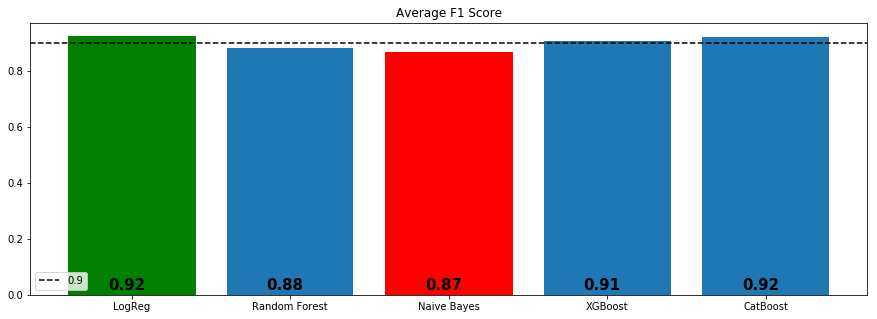

In [33]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 2. Synthetic Minority Oversampling Technique (SMOTE)

In [34]:
from collections import Counter
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)
df_text, df_target = sm.fit_sample(count_vect_train, y_train)
print (df_text.shape)
print (df_target.shape)

(11582, 3991)
(11582,)


In [35]:
from collections import Counter
Counter(df_target)

Counter({1: 5791, 0: 5791})

## 2.1 Logistic Regression

In [36]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_logreg = y_pred

f1 score: 0.8469868034601775


### Classification Report

In [37]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_logreg))

              precision    recall  f1-score   support

           0       0.41      0.60      0.49       294
           1       0.93      0.87      0.90      1940

    accuracy                           0.83      2234
   macro avg       0.67      0.73      0.69      2234
weighted avg       0.87      0.83      0.85      2234



### Confusion Matrix

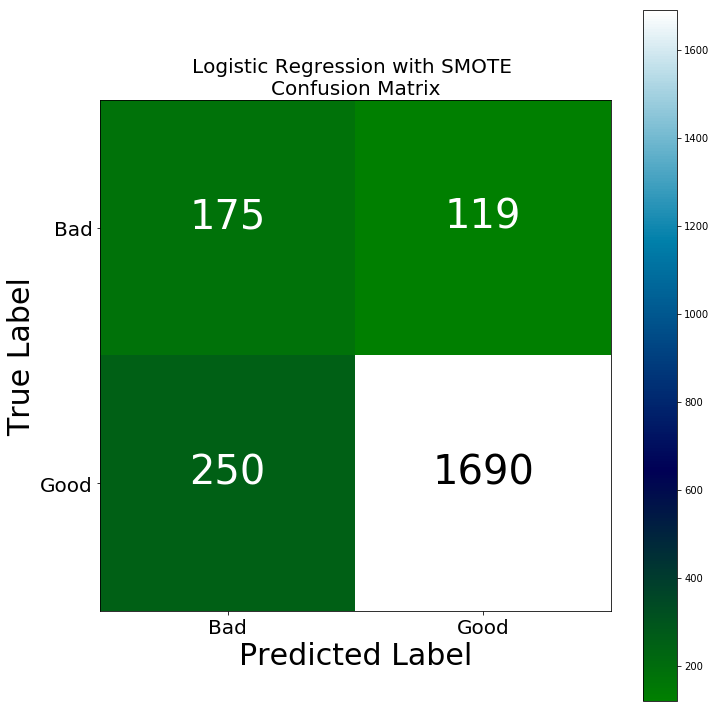

In [38]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_sm_logreg, "Logistic Regression", "SMOTE")

## 2.2 Random Forest

In [39]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_rf = y_pred

f1 score: 0.8588256778309529


### Classification Report

In [40]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_rf))

              precision    recall  f1-score   support

           0       0.53      0.31      0.39       294
           1       0.90      0.96      0.93      1940

    accuracy                           0.87      2234
   macro avg       0.72      0.64      0.66      2234
weighted avg       0.85      0.87      0.86      2234



### Confusion Matrix

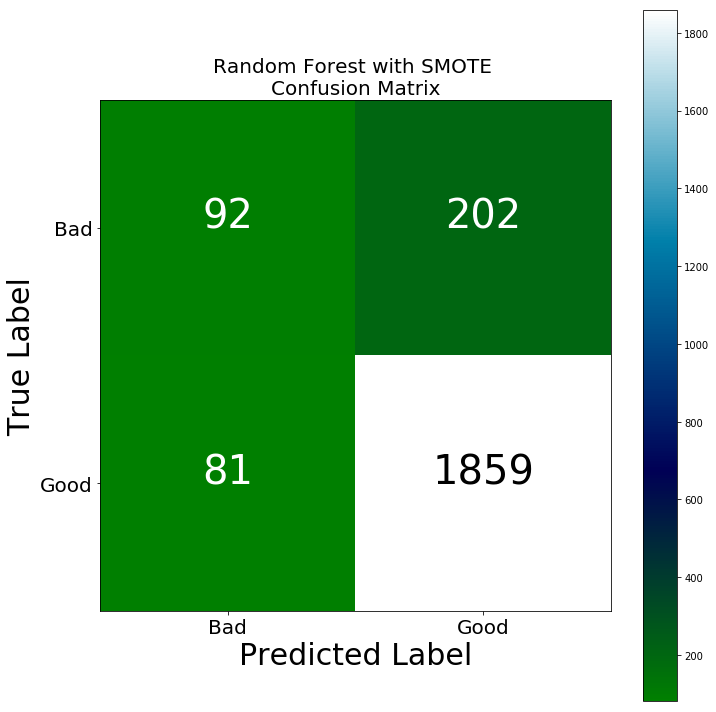

In [41]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_sm_rf, "Random Forest", "SMOTE")

## 2.3 Naive Bayes

In [42]:
# Call the modeling function for naive bayes and print f1 score
modeling(MultinomialNB(), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_nb = y_pred

f1 score: 0.8445664080427526


### Classification Report

In [43]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_nb))

              precision    recall  f1-score   support

           0       0.41      0.63      0.49       294
           1       0.94      0.86      0.90      1940

    accuracy                           0.83      2234
   macro avg       0.67      0.74      0.70      2234
weighted avg       0.87      0.83      0.84      2234



### Confusion Matrix

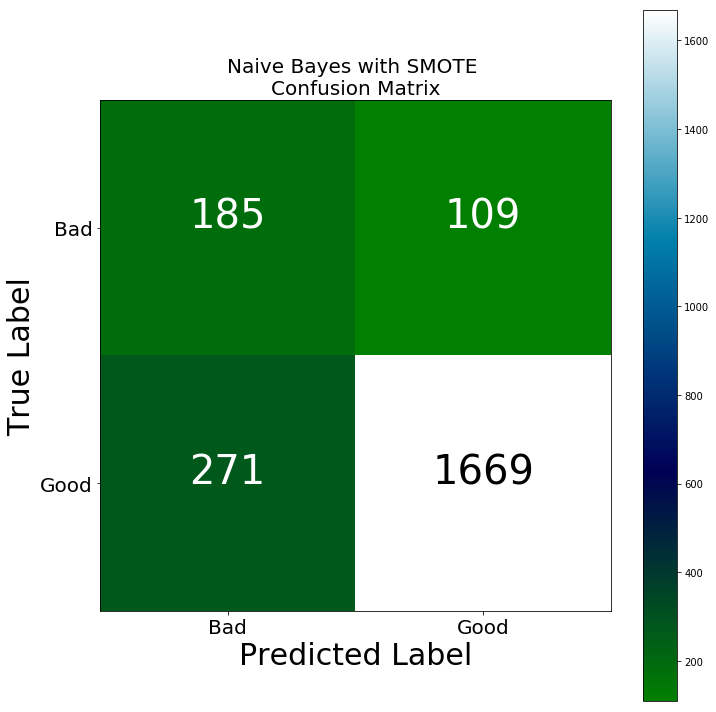

In [44]:
# Print confusion matrix for naive bayes
disp_confusion_matrix(y_pred_sm_nb, "Naive Bayes", "SMOTE")

## 2.4 XGBoost

In [45]:
# Call the modeling function for XGBoost and print f1 score
modeling(XGBClassifier(), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_xgb = y_pred

f1 score: 0.777170745221974


### Classification Report

In [46]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_xgb))

              precision    recall  f1-score   support

           0       0.29      0.64      0.39       294
           1       0.93      0.76      0.84      1940

    accuracy                           0.74      2234
   macro avg       0.61      0.70      0.62      2234
weighted avg       0.85      0.74      0.78      2234



### Confusion Matrix

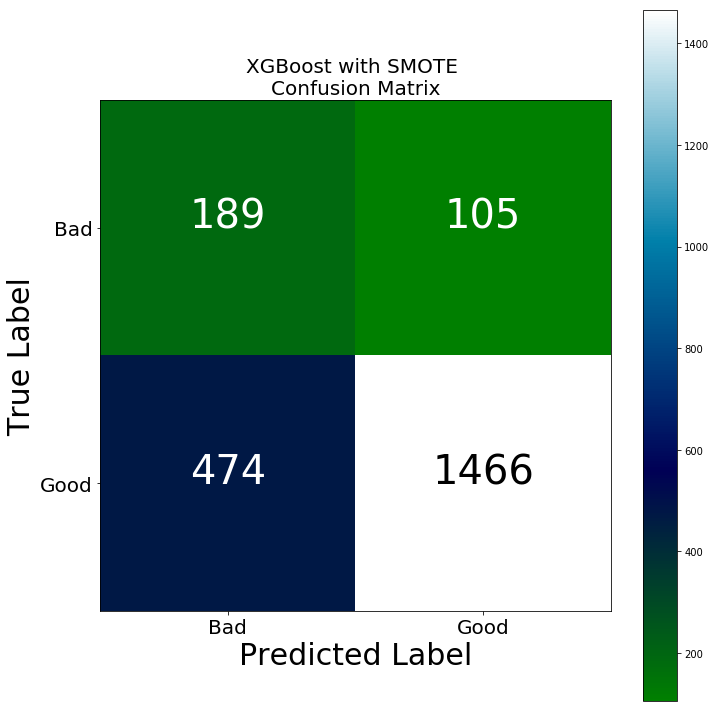

In [47]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_sm_xgb, "XGBoost", "SMOTE")

## 2.5 CatBoost

In [48]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = df_text, ytrain = df_target)

# Assign y_pred to a variable for further process
y_pred_sm_catboost = y_pred

0:	learn: 0.6384703	total: 38.2ms	remaining: 3.78s
1:	learn: 0.6186935	total: 57.8ms	remaining: 2.83s
2:	learn: 0.6051132	total: 84.4ms	remaining: 2.73s
3:	learn: 0.5929026	total: 103ms	remaining: 2.48s
4:	learn: 0.5824613	total: 124ms	remaining: 2.35s
5:	learn: 0.5729296	total: 146ms	remaining: 2.29s
6:	learn: 0.5632454	total: 167ms	remaining: 2.21s
7:	learn: 0.5547075	total: 189ms	remaining: 2.17s
8:	learn: 0.5477563	total: 209ms	remaining: 2.11s
9:	learn: 0.5386557	total: 230ms	remaining: 2.07s
10:	learn: 0.5293699	total: 252ms	remaining: 2.04s
11:	learn: 0.5224573	total: 274ms	remaining: 2.01s
12:	learn: 0.5113911	total: 294ms	remaining: 1.97s
13:	learn: 0.5039925	total: 323ms	remaining: 1.99s
14:	learn: 0.4980672	total: 342ms	remaining: 1.94s
15:	learn: 0.4913425	total: 369ms	remaining: 1.93s
16:	learn: 0.4864091	total: 386ms	remaining: 1.89s
17:	learn: 0.4806306	total: 407ms	remaining: 1.85s
18:	learn: 0.4779411	total: 429ms	remaining: 1.83s
19:	learn: 0.4728620	total: 450ms	rema

### Classification Report

In [49]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_sm_catboost))

              precision    recall  f1-score   support

           0       0.31      0.60      0.41       294
           1       0.93      0.80      0.86      1940

    accuracy                           0.77      2234
   macro avg       0.62      0.70      0.63      2234
weighted avg       0.85      0.77      0.80      2234



### Confusion Matrix

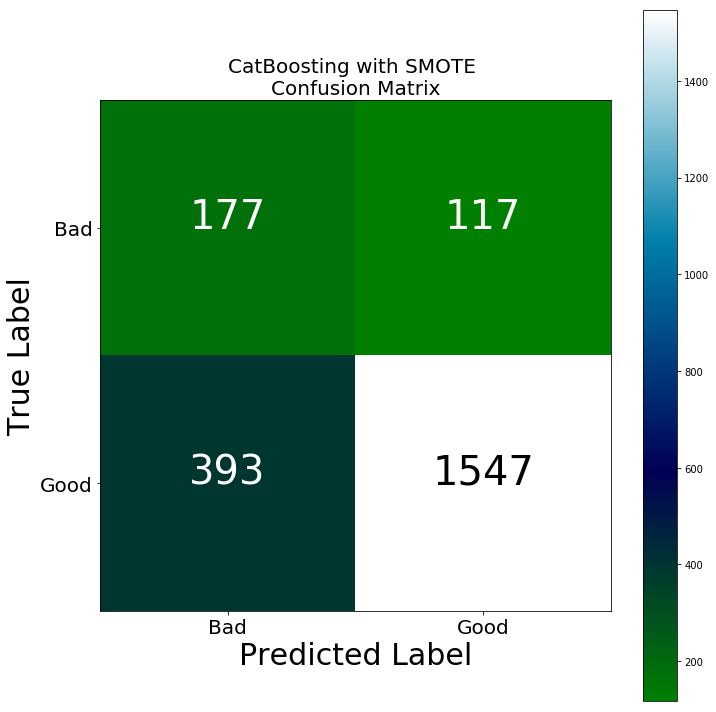

In [50]:
# Print confusion matrix for CatBoost
disp_confusion_matrix(y_pred_sm_catboost, "CatBoosting", "SMOTE")

## 2.6 Comparison of SMOTE Models

In [51]:
comparison_table(y_preds = [y_pred_sm_logreg, y_pred_sm_rf, y_pred_sm_nb, y_pred_sm_xgb, y_pred_sm_catboost], 
                 labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'] )

In [52]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with SMOTE\n')
df_tv2


Comparision Matrix of Modeling with SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.834825 bad       0.411765  0.595238  0.486787   
                                  good      0.934218  0.871134  0.901574   
                                  average   0.865462  0.834825  0.846987   
           Random Forest 0.873321 bad       0.531792  0.312925  0.394004   
                                  good      0.901989  0.958247  0.929268   
                                  average   0.853270  0.873321  0.858826   
           Naive Bayes   0.829902 bad       0.405702  0.629252  0.493333   
                                  good      0.938695  0.860309  0.897795   
                                  average   0.868552  0.829902  0.844566   
           XGBoost       0.740824 bad       0.285068  0.642857  0.394984   
                                  good      0.933164  0.755670  0.835090   
                                  average   0.847873  0.740824  0.777171   
           CatBoost      0.771710 bad       0.310526  0.602041  0.409722   
                                  good      0.929688  0.797423  0.858491   
                                  average   0.848204  0.771710  0.799432   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.834825 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           Random Forest 0.873321 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           Naive Bayes   0.829902 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           XGBoost       0.740824 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           CatBoost      0.771710 bad        294.0  
                                  good      1940.0  
                                  average   2234.0

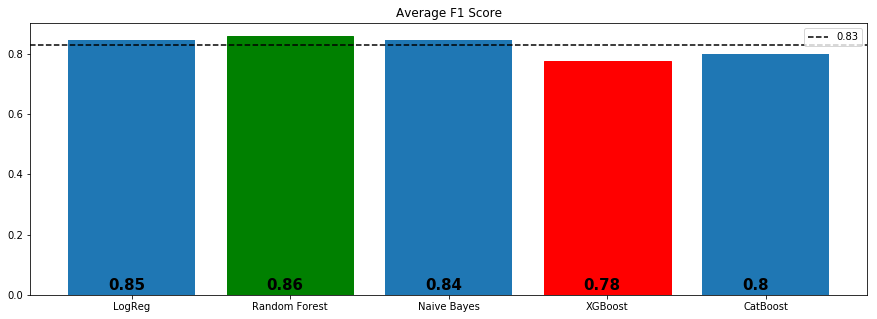

In [53]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 3. Applying PCA to Decrease the Linear Dimensionality + SMOTE

In [54]:
from sklearn.decomposition import PCA
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.975)
pca = PCA(random_state=42)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
pca_X_train = pca.fit_transform(count_vect_train)

count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()
pca_X_test = pca.transform(count_vect_test)

In [55]:
sm = SMOTE(random_state=42)
pca_text, pca_target = sm.fit_sample(pca_X_train, y_train)
print (pca_text.shape)
print (pca_target.shape)

(11582, 3991)
(11582,)


In [56]:
Counter(pca_target)

Counter({1: 5791, 0: 5791})

## 3.1 Logistic Regression

In [57]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_logreg = y_pred

f1 score: 0.9030209099466537


### Classification Report

In [58]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_logreg))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65       294
           1       0.95      0.93      0.94      1940

    accuracy                           0.90      2234
   macro avg       0.78      0.81      0.79      2234
weighted avg       0.91      0.90      0.90      2234



### Confusion Matrix

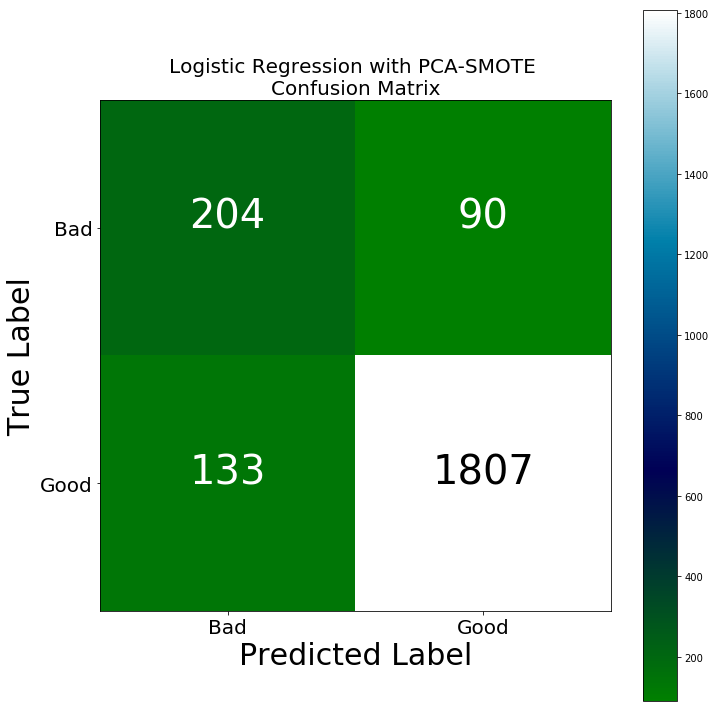

In [59]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_pcasm_logreg, "Logistic Regression", "PCA-SMOTE")

## 3.2 Random Forest

In [60]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_rf = y_pred

f1 score: 0.8209990526430764


### Classification Report

In [61]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_rf))

              precision    recall  f1-score   support

           0       0.59      0.05      0.10       294
           1       0.87      0.99      0.93      1940

    accuracy                           0.87      2234
   macro avg       0.73      0.52      0.51      2234
weighted avg       0.84      0.87      0.82      2234



### Confusion Matrix

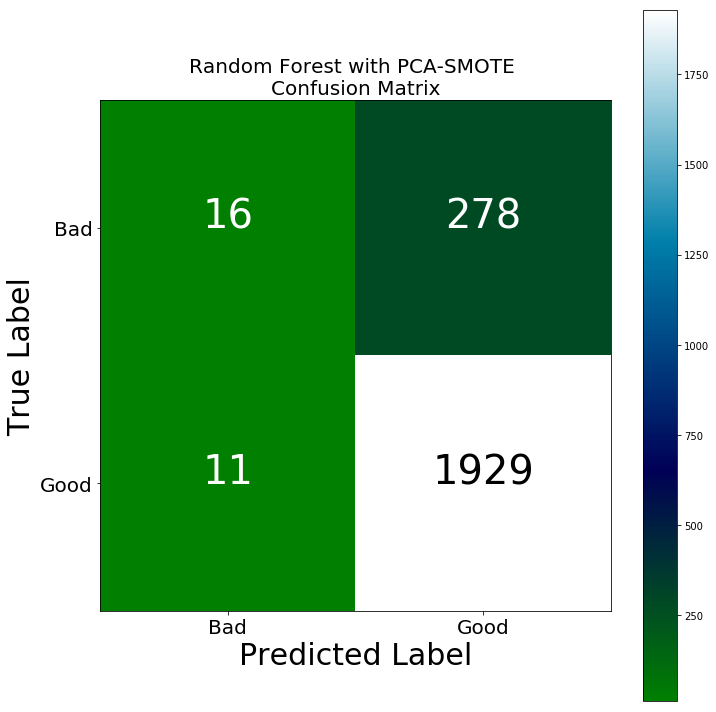

In [62]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_pcasm_rf, "Random Forest", "PCA-SMOTE")

## 3.3 XGBoost

In [63]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_xgb = y_pred

f1 score: 0.8074542975573964


### Classification Report

In [64]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_xgb))

              precision    recall  f1-score   support

           0       0.19      0.01      0.02       294
           1       0.87      0.99      0.93      1940

    accuracy                           0.86      2234
   macro avg       0.53      0.50      0.47      2234
weighted avg       0.78      0.86      0.81      2234



### Confusion Matrix

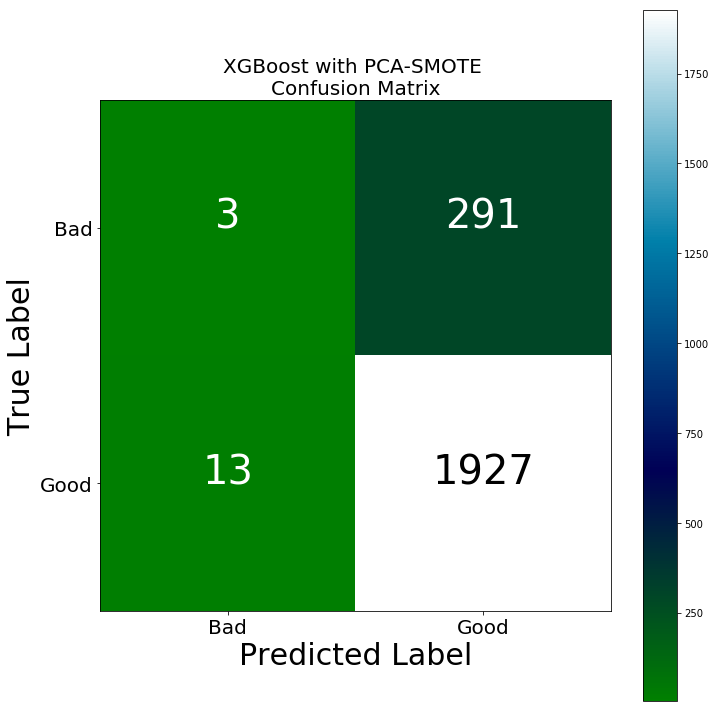

In [65]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_pcasm_xgb, "XGBoost", "PCA-SMOTE")

## 3.4 CatBoost

In [66]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = pca_text, Xtest = pca_X_test, ytrain = pca_target)

# Assign y_pred to a variable for further process
y_pred_pcasm_catboost = y_pred

0:	learn: 0.5760043	total: 120ms	remaining: 11.9s
1:	learn: 0.5423737	total: 217ms	remaining: 10.6s
2:	learn: 0.5111042	total: 309ms	remaining: 9.99s
3:	learn: 0.4859408	total: 402ms	remaining: 9.65s
4:	learn: 0.4650339	total: 496ms	remaining: 9.43s
5:	learn: 0.4356194	total: 596ms	remaining: 9.33s
6:	learn: 0.4166240	total: 687ms	remaining: 9.13s
7:	learn: 0.3975207	total: 780ms	remaining: 8.97s
8:	learn: 0.3846526	total: 870ms	remaining: 8.79s
9:	learn: 0.3676525	total: 965ms	remaining: 8.69s
10:	learn: 0.3557953	total: 1.06s	remaining: 8.56s
11:	learn: 0.3469964	total: 1.15s	remaining: 8.42s
12:	learn: 0.3372382	total: 1.24s	remaining: 8.28s
13:	learn: 0.3283241	total: 1.33s	remaining: 8.15s
14:	learn: 0.3193481	total: 1.43s	remaining: 8.08s
15:	learn: 0.3126022	total: 1.52s	remaining: 7.97s
16:	learn: 0.3052054	total: 1.61s	remaining: 7.86s
17:	learn: 0.2997560	total: 1.7s	remaining: 7.75s
18:	learn: 0.2931318	total: 1.8s	remaining: 7.67s
19:	learn: 0.2831618	total: 1.9s	remaining:

### Classification Report

In [67]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_pcasm_catboost))

              precision    recall  f1-score   support

           0       0.45      0.13      0.20       294
           1       0.88      0.98      0.93      1940

    accuracy                           0.86      2234
   macro avg       0.66      0.55      0.56      2234
weighted avg       0.82      0.86      0.83      2234



### Confusion Matrix

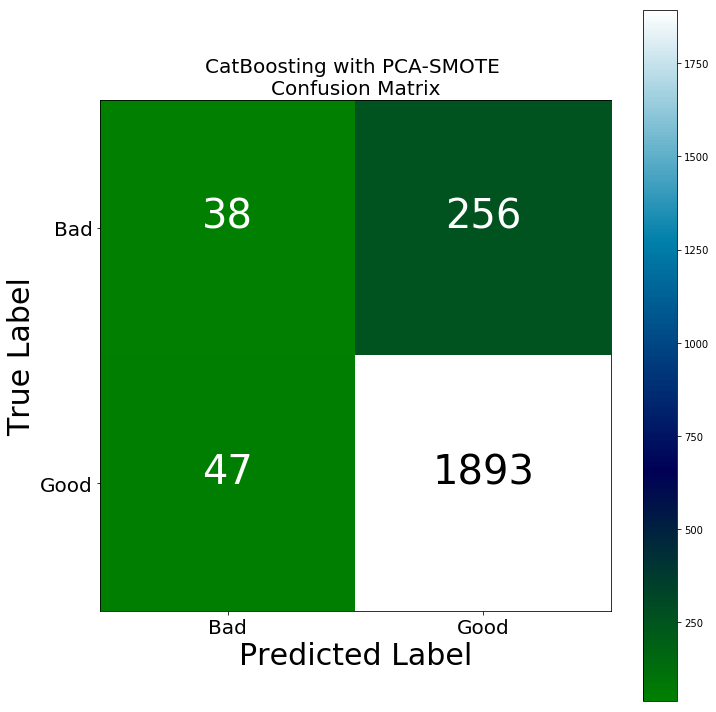

In [68]:
# Print confusion matrix for CatBoost 
disp_confusion_matrix(y_pred_pcasm_catboost, "CatBoosting", "PCA-SMOTE")

## 3.5 Comparison of PCA-SMOTE Models

In [69]:
comparison_table(y_preds = [y_pred_pcasm_logreg, y_pred_pcasm_rf, y_pred_pcasm_xgb, y_pred_pcasm_catboost], 
                 labels = ['LogReg', 'Random Forest', 'XGBoost', 'CatBoost'])

In [70]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with PCA & SMOTE\n')
df_tv2


Comparision Matrix of Modeling with PCA & SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.900179 bad       0.605341  0.693878  0.646593   
                                  good      0.952557  0.931443  0.941882   
                                  average   0.906862  0.900179  0.903021   
           Random Forest 0.870636 bad       0.592593  0.054422  0.099688   
                                  good      0.874037  0.994330  0.930311   
                                  average   0.836998  0.870636  0.820999   
           XGBoost       0.863921 bad       0.187500  0.010204  0.019355   
                                  good      0.868801  0.993299  0.926888   
                                  average   0.779140  0.863921  0.807454   
           CatBoost      0.864369 bad       0.447059  0.129252  0.200528   
                                  good      0.880875  0.975773  0.925899   
                                  average   0.823784  0.864369  0.830438   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.900179 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           Random Forest 0.870636 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           XGBoost       0.863921 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           CatBoost      0.864369 bad        294.0  
                                  good      1940.0  
                                  average   2234.0

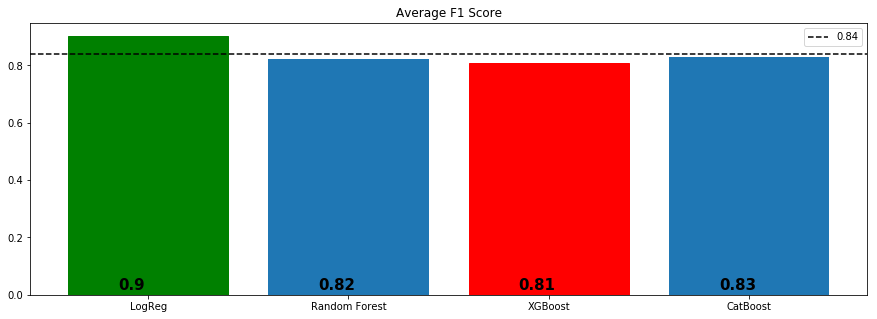

In [71]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 4. Truncated SVD + SMOTE

In [72]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(random_state=42)
svd_X_train = svd.fit_transform(count_vect_train)
svd_X_test = svd.transform(count_vect_test)

### SMOTE

In [73]:
sm = SMOTE(random_state=5)
df_ttext, df_ttarget = sm.fit_sample(svd_X_train, y_train)

print (df_ttext.shape)
print (df_ttarget.shape)

(11582, 2)
(11582,)


In [74]:
Counter(df_ttarget)

Counter({1: 5791, 0: 5791})

## 4.1 Logistic Regression

In [75]:
# Call the modeling function for logistic regression and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, 
                            random_state = 42), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_logreg = y_pred

f1 score: 0.870562723969646


### Classification Report

In [76]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_logreg))

              precision    recall  f1-score   support

           0       0.48      0.69      0.57       294
           1       0.95      0.89      0.92      1940

    accuracy                           0.86      2234
   macro avg       0.71      0.79      0.74      2234
weighted avg       0.89      0.86      0.87      2234



### Confusion Matrix

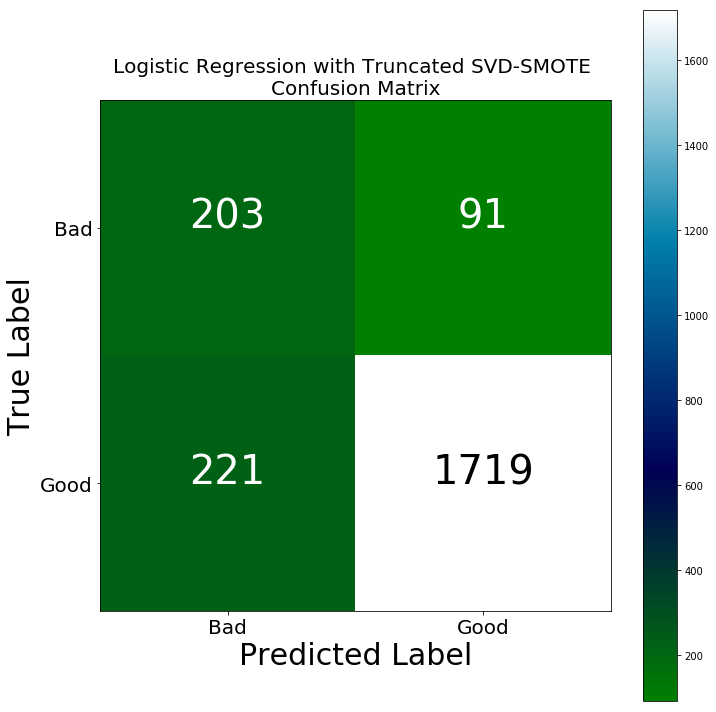

In [77]:
# Print confusion matrix for logistic regression 
disp_confusion_matrix(y_pred_svd_logreg, "Logistic Regression", "Truncated SVD-SMOTE")

## 4.2 Random Forest

In [78]:
# Call the modeling function for random forest classifier and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_rf = y_pred

f1 score: 0.8499710044399331


### Classification Report

In [79]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_rf))

              precision    recall  f1-score   support

           0       0.42      0.66      0.51       294
           1       0.94      0.86      0.90      1940

    accuracy                           0.84      2234
   macro avg       0.68      0.76      0.71      2234
weighted avg       0.88      0.84      0.85      2234



### Confusion Matrix

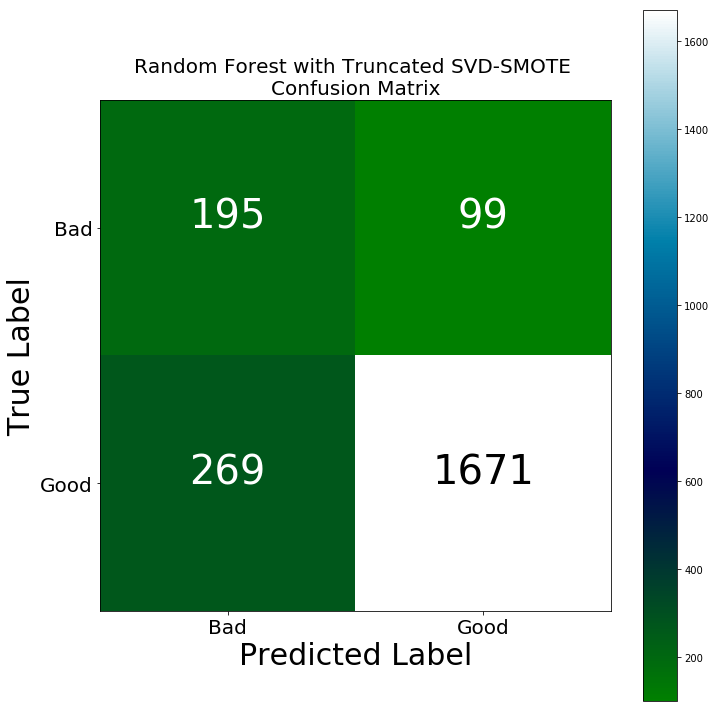

In [80]:
# Print confusion matrix for random forest classifier
disp_confusion_matrix(y_pred_svd_rf, "Random Forest", "Truncated SVD-SMOTE")

## 4.3 XGBoost

In [81]:
# Call the modeling function for XGBoost and print f1 score
modeling(XGBClassifier(), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_xgb = y_pred

f1 score: 0.8642072492498548


### Classification Report

In [82]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_xgb))

              precision    recall  f1-score   support

           0       0.46      0.70      0.55       294
           1       0.95      0.87      0.91      1940

    accuracy                           0.85      2234
   macro avg       0.70      0.79      0.73      2234
weighted avg       0.89      0.85      0.86      2234



### Confusion Matrix

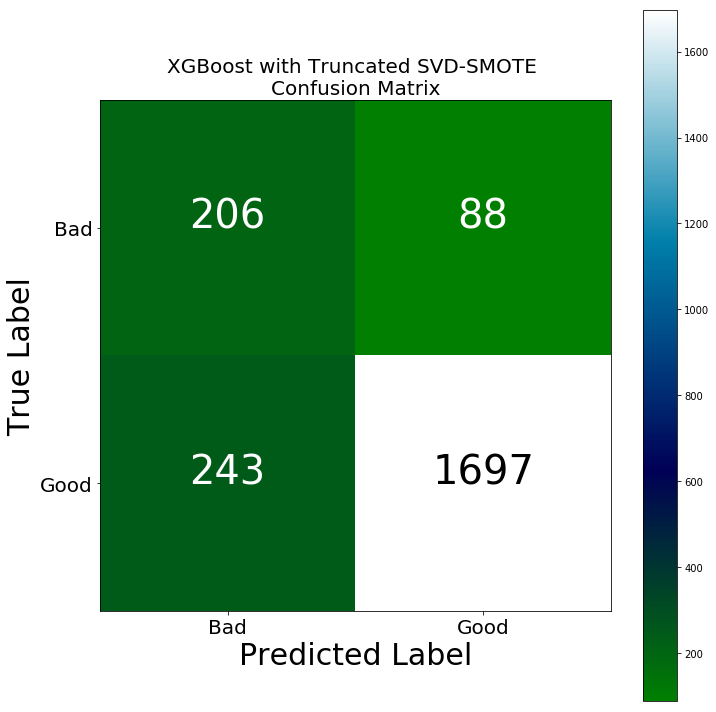

In [83]:
# Print confusion matrix for XGBoost
disp_confusion_matrix(y_pred_svd_xgb, "XGBoost", "Truncated SVD-SMOTE")

## 4.4 CatBoost

In [84]:
# Call the modeling function for Catboost and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), Xtrain = df_ttext, Xtest = svd_X_test, ytrain = df_ttarget)

# Assign y_pred to a variable for further process
y_pred_svd_catboost = y_pred

0:	learn: 0.4809395	total: 13ms	remaining: 1.29s
1:	learn: 0.4406718	total: 17.9ms	remaining: 878ms
2:	learn: 0.4280484	total: 23.1ms	remaining: 748ms
3:	learn: 0.4245886	total: 28.5ms	remaining: 683ms
4:	learn: 0.4201191	total: 34.3ms	remaining: 651ms
5:	learn: 0.4181008	total: 40ms	remaining: 627ms
6:	learn: 0.4161299	total: 45.3ms	remaining: 602ms
7:	learn: 0.4148108	total: 52ms	remaining: 598ms
8:	learn: 0.4129982	total: 59.7ms	remaining: 604ms
9:	learn: 0.4127796	total: 65.6ms	remaining: 590ms
10:	learn: 0.4114052	total: 72.1ms	remaining: 583ms
11:	learn: 0.4108730	total: 77.6ms	remaining: 569ms
12:	learn: 0.4094548	total: 82.4ms	remaining: 551ms
13:	learn: 0.4089614	total: 88.3ms	remaining: 543ms
14:	learn: 0.4070554	total: 94.1ms	remaining: 533ms
15:	learn: 0.4068646	total: 98.8ms	remaining: 519ms
16:	learn: 0.4063061	total: 106ms	remaining: 515ms
17:	learn: 0.4053274	total: 111ms	remaining: 506ms
18:	learn: 0.4044759	total: 116ms	remaining: 493ms
19:	learn: 0.4041643	total: 123

### Classification Report

In [85]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_svd_catboost))

              precision    recall  f1-score   support

           0       0.44      0.68      0.54       294
           1       0.95      0.87      0.91      1940

    accuracy                           0.84      2234
   macro avg       0.69      0.77      0.72      2234
weighted avg       0.88      0.84      0.86      2234



### Confusion Matrix

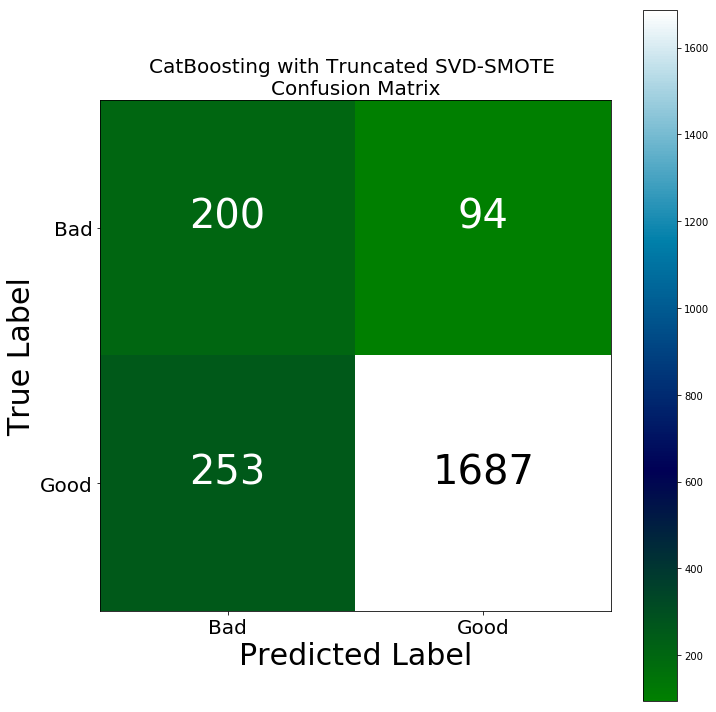

In [86]:
# Print confusion matrix for CatBoost 
disp_confusion_matrix(y_pred_svd_catboost, "CatBoosting", "Truncated SVD-SMOTE")

## 4.5 Comparison of Models

In [87]:
comparison_table(y_preds = [y_pred_svd_logreg, y_pred_svd_rf, y_pred_svd_xgb, y_pred_svd_catboost], 
                 labels = ['LogReg', 'Random Forest', 'XGBoost', 'CatBoost'])

In [88]:
# Print the comparision matrix
print('\nComparision Matrix of Modeling with SMOTE\n')
df_tv2


Comparision Matrix of Modeling with SMOTE



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.860340 bad       0.478774  0.690476  0.565460   
                                  good      0.949724  0.886082  0.916800   
                                  average   0.887746  0.860340  0.870563   
           Random Forest 0.835273 bad       0.420259  0.663265  0.514512   
                                  good      0.944068  0.861340  0.900809   
                                  average   0.875133  0.835273  0.849971   
           XGBoost       0.851835 bad       0.458797  0.700680  0.554509   
                                  good      0.950700  0.874742  0.911141   
                                  average   0.885965  0.851835  0.864207   
           CatBoost      0.844673 bad       0.441501  0.680272  0.535475   
                                  good      0.947221  0.869588  0.906745   
                                  average   0.880667  0.844673  0.857885   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.860340 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           Random Forest 0.835273 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           XGBoost       0.851835 bad        294.0  
                                  good      1940.0  
                                  average   2234.0  
           CatBoost      0.844673 bad        294.0  
                                  good      1940.0  
                                  average   2234.0

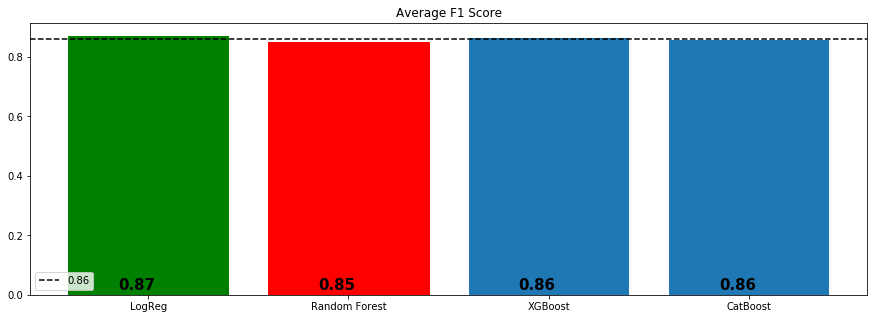

In [89]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")